In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import nltk
from tqdm import tqdm
import torch

nltk.download('punkt')
nltk.download('stopwords')

file_path = '/content/Sherlock Holmes.txt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
with open(file_path, 'r', encoding='utf-8') as file:
  text = file.read()

print(text[:300])





                        THE ADVENTURES OF SHERLOCK HOLMES

                               Arthur Conan Doyle



                                Table of contents

               A Scandal in Bohemia
               The Red-Headed League
               A Case of Identity
               The Boscomb


**Upon a quick manual inspection of the corpus, it was observed that it contained twelve stories.**

In [4]:
story_titles = [title.lower() for title in [
    "A Scandal in Bohemia",
    "The Red-Headed League",
    "A Case of Identity",
    "The Boscombe Valley Mystery",
    "The Five Orange Pips",
    "The Man with the Twisted Lip",
    "The Adventure of the Blue Carbuncle",
    "The Adventure of the Speckled Band",
    "The Adventure of the Engineer's Thumb",
    "The Adventure of the Noble Bachelor",
    "The Adventure of the Beryl Coronet",
    "The Adventure of the Copper Beeches"
]]

# Split text into stories
stories = {}
current_story = None

# Skipping intro
for line in text[730:].split('\n'):
  if line.strip().lower() in story_titles:
    current_story = line.strip().lower()
    stories[current_story] = ""
  elif current_story:
    stories[current_story] += line + '\n'

story_titles = [t.lower() for t in [
    "A Scandal in Bohemia",
    "The Red-Headed League",
    "A Case of Identity",
    "The Boscombe Valley Mystery",
    "The Five Orange Pips",
    "The Man with the Twisted Lip",
    "The Adventure of the Blue Carbuncle",
    "The Adventure of the Speckled Band",
    "The Adventure of the Engineer's Thumb",
    "The Adventure of the Noble Bachelor",
    "The Adventure of the Beryl Coronet",
    "The Adventure of the Copper Beeches"
]]

# Split the text into stories
stories = {}
current_story = None
for line in text[730:].split('\n'):
    if line.strip().lower() in story_titles:
        current_story = line.strip().lower()

        stories[current_story] = ""
    elif current_story:
        stories[current_story] += line + '\n'


print(f"Total stories extracted: {len(stories)}")
first_title = list(stories.keys())[0]
print(f"First story: {first_title}, Content Preview: {stories[first_title][:1000]}")

Total stories extracted: 12
First story: a scandal in bohemia, Content Preview: 




                                Table of contents
                                     Chapter 1
                                     Chapter 2
                                     Chapter 3















          CHAPTER I



     To Sherlock Holmes she is always the woman. I have seldom heard him
     mention her under any other name. In his eyes she eclipses and
     predominates the whole of her sex. It was not that he felt any
     emotion akin to love for Irene Adler. All emotions, and that one
     particularly, were abhorrent to his cold, precise but admirably
     balanced mind. He was, I take it, the most perfect reasoning and
     observing machine that the world has seen, but as a lover he would
     have placed himself in a false position. He never spoke of the softer
     passions, save with a gibe and a sneer. They were admirable things
     for the observer--excellent for drawing the 

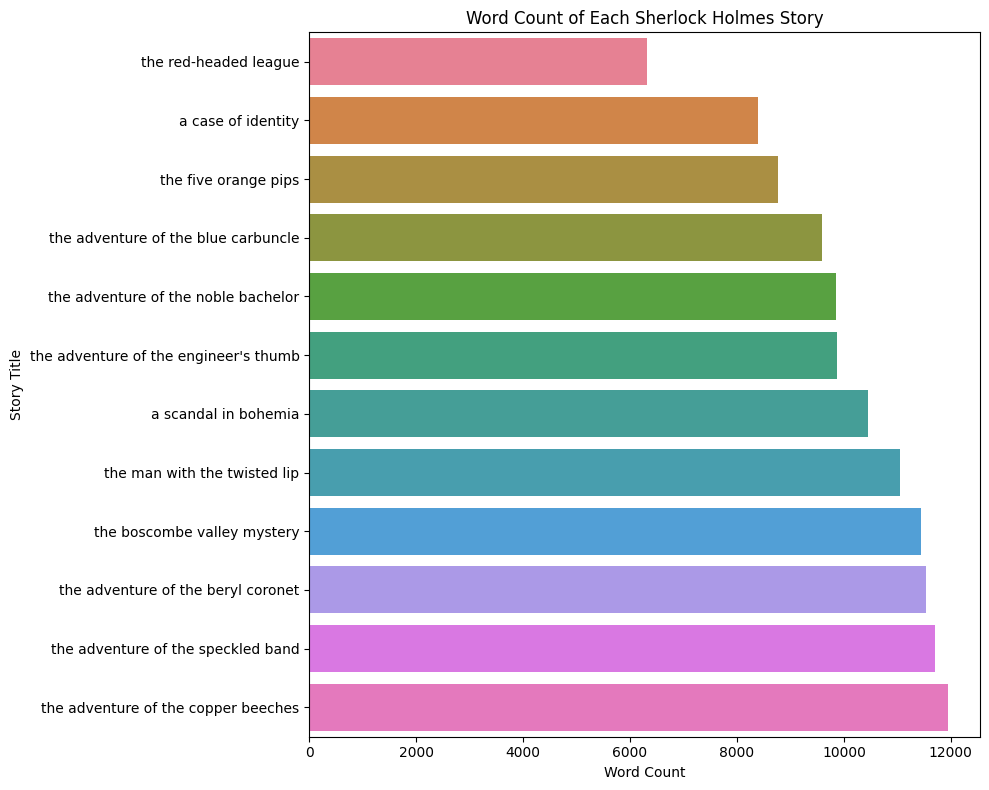

In [5]:
word_counts = {title: len(word_tokenize(text)) for title, text in stories.items()}

word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['Story Title', 'Word Count'])

plt.figure(figsize=(10, 8))
sns.barplot(x='Word Count', y='Story Title', data=word_counts_df.sort_values('Word Count'), hue='Story Title')
plt.title('Word Count of Each Sherlock Holmes Story')
plt.xlabel('Word Count')
plt.ylabel('Story Title')
plt.tight_layout()

**The stories varied in length, with "The Red-Headed League" being the shortest at approximately 7,000 words, while "The Adventure of the Copper Beeches" is the longest, totaling around 12,000 words.**

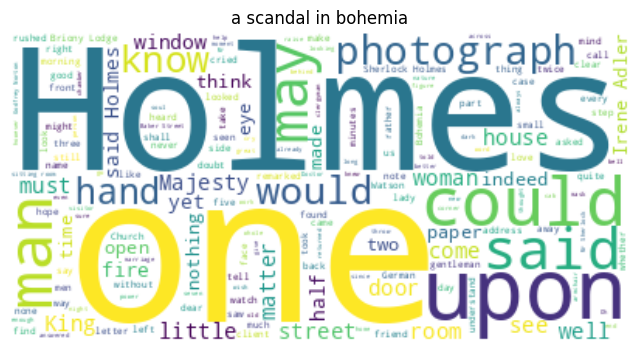

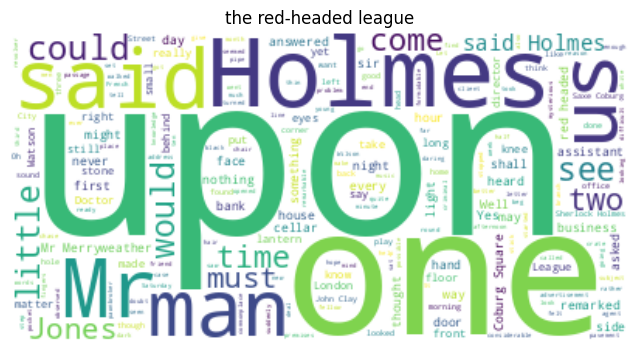

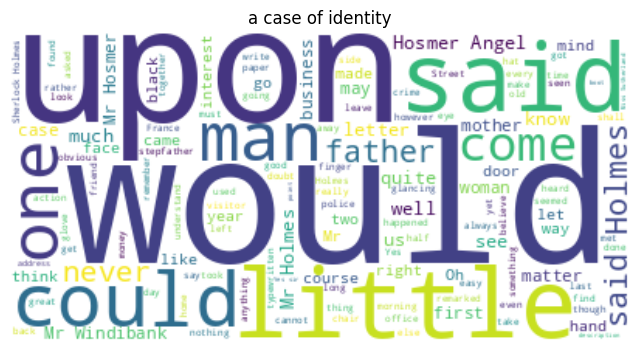

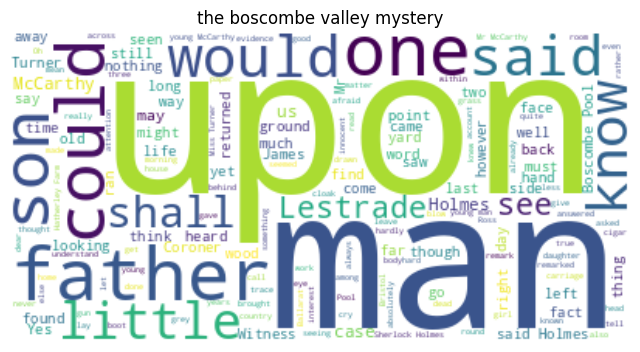

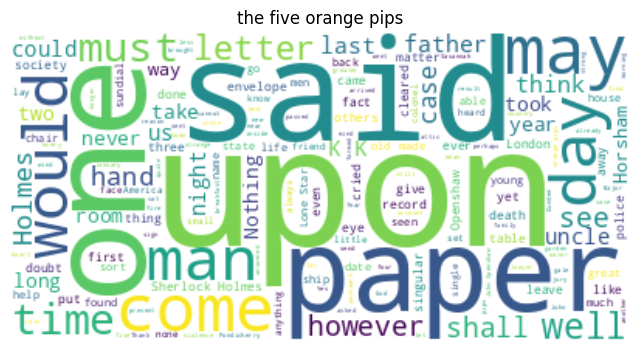

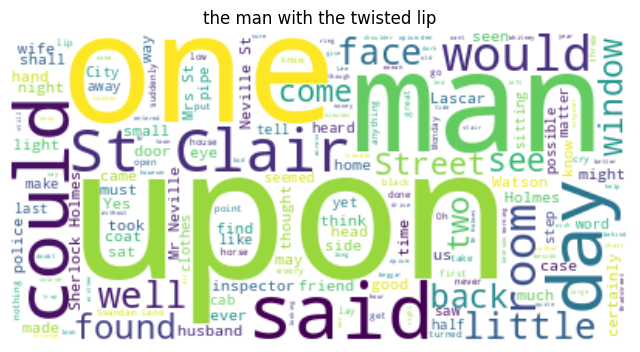

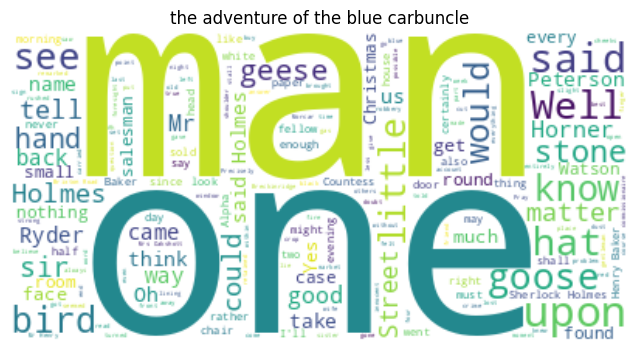

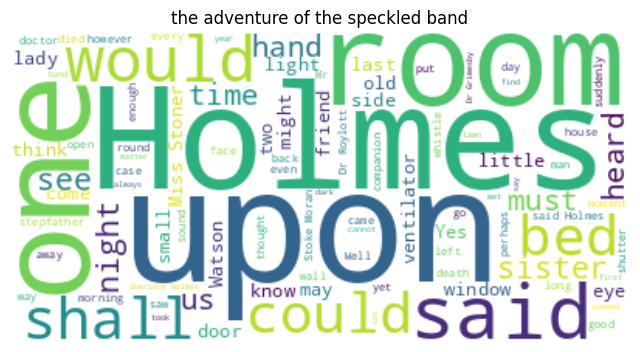

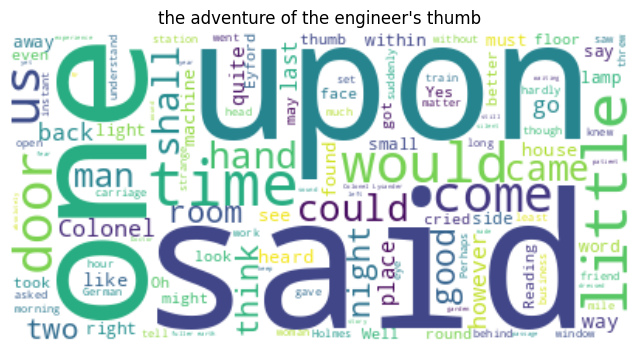

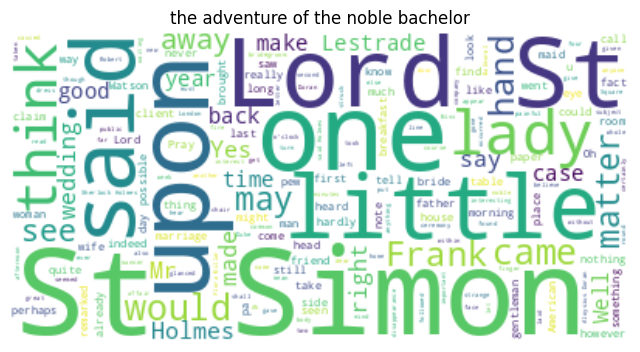

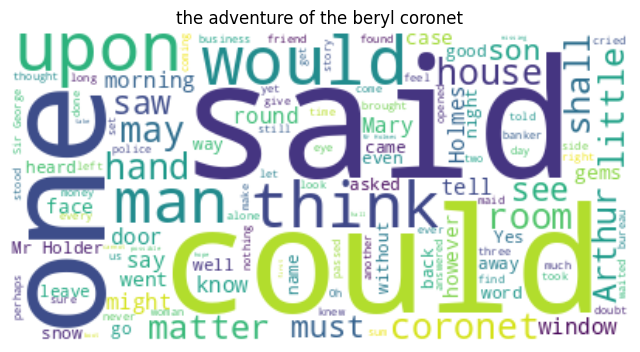

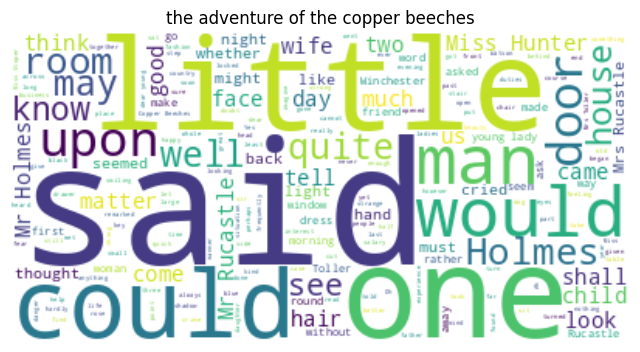

In [6]:
from wordcloud import WordCloud

# Create a function to generate a word cloud for each story
def generate_wordcloud(title, text):
    wordcloud = WordCloud(stopwords=set(stopwords.words('english')), background_color='white').generate(text)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate a word cloud for each story
for title, text in stories.items():
    generate_wordcloud(title, text)

The Type-Token Ratio (TTR) is a linguistic measure that assesses the diversity of vocabulary in a text by comparing the number of unique words (types) to the total number of words (tokens).

This ratio can vary between 0 and 1, with higher values indicating greater lexical variety. For example, if a text contains 400 unique words out of 1,000 total words, the TTR would be 40%.

In [1]:
def calculate_ttr(text):
  tokens = word_tokenize(text.lower())
  types = set(tokens)
  return len(types) / len(tokens) if tokens else 0

ttr = {title: calculate_ttr(text) for title, text in stories.items()}

ttr_df = pd.DataFrame(list(ttr.items()), columns=['Story Title', 'Type-Token Ratio'])

plt.figure(figsize=(10, 8))
sns.barplot(x='Type-Token Ratio', y='Story Title', data=ttr_df.sort_values('Type-Token Ratio', ascending=False))
plt.title('Type-Token Ratio of Each Sherlock Holmes Story')
plt.xlabel('Type-Token Ratio')
plt.ylabel('Story Title')
plt.tight_layout()

NameError: name 'stories' is not defined

In [ ]:
def calculate_avg_sentence_length(text):
    sentences = sent_tokenize(text)
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    return sum(sentence_lengths) / len(sentence_lengths) if sentence_lengths else 0

avg_sentence_length = {title: calculate_avg_sentence_length(text) for title, text in stories.items()}

sentence_length_df = pd.DataFrame(list(avg_sentence_length.items()), columns=['Story Title', 'Average Sentence Length'])

plt.figure(figsize=(10, 8))
sns.barplot(x='Average Sentence Length', y='Story Title', data=sentence_length_df.sort_values('Average Sentence Length', ascending=False))
plt.title('Average Sentence Length of Each Sherlock Holmes Story')
plt.xlabel('Average Sentence Length')
plt.ylabel('Story Title')
plt.tight_layout()